# Analysis of generated data

Analyze experiment results, present findings. Notebook input is data, output is A/B test suggestions.

Menu backed up on Github.

### Import libraries

In [1]:
import pandas as pd
pd.options.display.max_rows = 10  # limit huge ouputs
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')  # plt.style.available

import warnings
warnings.filterwarnings("ignore")  # filter warnings

### Get data

Merge monthly order data into single .csv file. Raw files available on [Github](https://github.com/onederekchen/thaitanic/tree/main/data/raw_data).

In [2]:
path = "../data/raw_data/"

all_months_data = pd.DataFrame()

for file in os.listdir(path):
    if not file.startswith('.'):  # ignore hidden files
        current_month_data = pd.read_csv(path+file)
        all_months_data = pd.concat([all_months_data, current_month_data])

# remove unnamed column (fixed for future generations!)
all_months_data = all_months_data.loc[:, ~all_months_data.columns.str.contains('^Unnamed')]
    
# all_months_data.to_csv('all_data.csv', index=False)  # don't want to re-save csv every time

In [3]:
df = pd.read_csv("../data/all_data.csv").sort_values(by='Order Date', ascending=False)
df.reset_index(drop=True, inplace=True)
df

,Order ID,Product,Quantity Ordered,Price Each,Order Date
0,209412,Tom Yum Gai,1,12,2019-12-31 20:59:00
1,209411,Pad Kee Mao,1,12,2019-12-31 20:57:00
2,209397,Yellow Curry,1,12,2019-12-31 20:55:00
3,209417,Thai Fried Rice,1,12,2019-12-31 20:53:00
4,209402,Yum Woonsen,2,13,2019-12-31 20:51:00
...,...,...,...,...,...
216487,3925,Pad Char,1,15,2017-01-01 12:15:00
216488,3926,Sriracha Wings,1,10,2017-01-01 12:08:00
216489,3913,Grilled Salmon,1,22,2017-01-01 12:07:00
216490,3931,Pad Kee Mao,1,12,2017-01-01 12:06:00


# Clean data

In [4]:
df.isnull().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
dtype: int64

In [5]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

df.dtypes

Order ID                     int64
Product                     object
Quantity Ordered             int64
Price Each                   int64
Order Date          datetime64[ns]
dtype: object

# Augment data

In [6]:
df['Sales'] = df['Quantity Ordered'] * df['Price Each']

df['Year'] = df['Order Date'].dt.year

df['Month'] = df['Order Date'].dt.month

df['Weekday'] = df['Order Date'].dt.day_name()

df['Weekday Value'] = df['Order Date'].dt.weekday

df['Hour'] = df['Order Date'].dt.hour

# Explore data

In [7]:
df.describe()

,Order ID,Quantity Ordered,Price Each,Sales,Year,Month,Weekday Value,Hour
count,216492.000000,216492.000000,216492.000000,216492.000000,216492.000000,216492.000000,216492.000000,216492.000000
mean,106655.919203,1.125427,12.202977,13.733782,2018.009455,6.829329,3.731186,15.861454
std,59347.187553,0.684673,3.075631,9.269607,0.817747,3.498833,1.706770,2.958466
min,3910.000000,1.000000,6.000000,6.000000,2017.000000,1.000000,1.000000,11.000000
25%,55261.750000,1.000000,12.000000,12.000000,2017.000000,4.000000,2.000000,13.000000
50%,106677.500000,1.000000,12.000000,12.000000,2018.000000,7.000000,4.000000,17.000000
75%,158065.250000,1.000000,12.000000,12.000000,2019.000000,10.000000,5.000000,19.000000
max,209428.000000,9.000000,22.000000,198.000000,2019.000000,12.000000,6.000000,20.000000


The lowest Order ID is 3910: maybe Thaitanic started recording data (or switched to a new system) in December 2016, and just gave us data from January 2017 onwards. We're looking at about 6000 orders per month.

At least 75% of orders have a single order quantity (but someone ordered 9 somewhere! Maybe catering or some other large takeout option? It actually looks like the biggest sale ever was the most expensive item purchased 9 times... so might be an anomaly). 

The cheapest item is six dollars while the most expensive is 22.

### Duplicate values

In [8]:
dupes_df = df.loc[(df['Order ID'].duplicated(keep=False))]
dupes_df

# check for more than 2 dupes in one order (none found)
# grouped_df = df.groupby('Order ID').count()
# grouped_df.loc[(grouped_df['Product'])>2]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Sales,Year,Month,Weekday,Weekday Value,Hour
9,209426,Thai Fried Rice,1,12,2019-12-31 20:32:00,12,2019,12,Tuesday,1,20
11,209426,Sticky Rice with Mango,1,6,2019-12-31 20:32:00,6,2019,12,Tuesday,1,20
12,209427,Green Curry,1,12,2019-12-31 20:29:00,12,2019,12,Tuesday,1,20
13,209427,Sticky Rice with Mango,1,6,2019-12-31 20:29:00,6,2019,12,Tuesday,1,20
32,209418,Thai Beef Noodle Soup,1,12,2019-12-31 20:05:00,12,2019,12,Tuesday,1,20
...,...,...,...,...,...,...,...,...,...,...,...
216465,3924,Sticky Rice with Mango,3,6,2017-01-01 12:57:00,18,2017,1,Sunday,6,12
216476,3927,Grilled Salmon,1,22,2017-01-01 12:34:00,22,2017,1,Sunday,6,12
216478,3927,Sticky Rice with Mango,1,6,2017-01-01 12:34:00,6,2017,1,Sunday,6,12
216484,3922,Pad Thai,1,12,2017-01-01 12:17:00,12,2017,1,Sunday,6,12


The duplicate values look like a second item ordered within the same product ID. So there aren't erroneous duplicates, it's part of the order. Doesn't seem like a huge amount.

Also, there aren't any orders with 3 or more items.

Let's look at the order distribution.

In [9]:
dupes_df.groupby('Product').sum().sort_values(by='Quantity Ordered', ascending=False)

# sort by sales instead of quantity ordered
# dupes_df.groupby('Product').sum().sort_values(by='Sales', ascending=False)

,Order ID,Quantity Ordered,Price Each,Sales,Year,Month,Weekday Value,Hour
Product,,,,,,,,
Sticky Rice with Mango,1167497683,12385,66180,74310,22258568,74653,41022,175494
Chicken Satay,81713731,876,7650,8760,1543786,5134,2894,12085
Vegan Fresh Rolls,68330204,723,6260,7230,1263295,4280,2345,9797
Green Curry,57636253,612,6468,7344,1087707,3701,2030,8653
Pad Thai,57003653,603,6564,7236,1103837,3673,1988,8617
...,...,...,...,...,...,...,...,...
Pra Ram,12564668,140,1416,1680,238124,814,466,1866
Yum Nua,13518261,135,1464,1620,246203,849,434,1905
Yum Woonsen,12885849,132,1547,1716,240147,803,452,1879


Okay, the dupes are overwhelmingly the only dessert item on the menu. There's a drop off in other dishes, but it might just be related to the popularity of those items. What about orders that don't include sticky rice with mango?

Interestingly, sorting by sales gives a noticeably different ordering than just sorting by quantity ordered. Our goal is to give recommendations to maximize sales, so it's something to keep in mind.

In [10]:
# remove any orders paired with sticky rice

dupes_no_sticky_rice = df.loc[(df['Order ID'].duplicated(keep=False) & ~(df['Product'].str[0:6]=="Sticky"))]
remaining_dupes = dupes_no_sticky_rice.loc[(dupes_no_sticky_rice['Order ID'].duplicated(keep=False))]
remaining_dupes

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Sales,Year,Month,Weekday,Weekday Value,Hour
113,209322,Green Curry,1,12,2019-12-31 17:51:00,12,2019,12,Tuesday,1,17
114,209322,Vegan Fresh Rolls,1,10,2019-12-31 17:51:00,10,2019,12,Tuesday,1,17
330,209104,Red Curry,1,12,2019-12-29 19:30:00,12,2019,12,Sunday,6,19
332,209104,Chicken Satay,1,10,2019-12-29 19:30:00,10,2019,12,Sunday,6,19
535,208892,Sriracha Wings,1,10,2019-12-29 13:45:00,10,2019,12,Sunday,6,13
...,...,...,...,...,...,...,...,...,...,...,...
215094,5224,Vegan Fresh Rolls,1,10,2017-01-08 15:50:00,10,2017,1,Sunday,6,15
215382,4973,Chicken Satay,1,10,2017-01-07 14:23:00,10,2017,1,Saturday,5,14
215383,4973,Yum Nua,1,12,2017-01-07 14:23:00,12,2017,1,Saturday,5,14
216101,4280,MyThai Salad,1,12,2017-01-03 18:39:00,12,2017,1,Tuesday,1,18


Looks like it was mostly sticky rice, but there are still other duplicate orders which isn't unusual. Actually, I'm noticing a lot of these seem to be appetizers - let's see if there's a noticeable difference in the amount of appetizers vs other meals.

In [11]:
# show number of appetizers in duplicate orders (886)
remaining_dupes.loc[(remaining_dupes['Product'].str[0:5]=="Tom K") | 
                   (remaining_dupes['Product'].str[0:5]=="Srira") | 
                   (remaining_dupes['Product'].str[0:5]=="Chick") | 
                   (remaining_dupes['Product'].str[0:5]=="Vegan")]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Sales,Year,Month,Weekday,Weekday Value,Hour
114,209322,Vegan Fresh Rolls,1,10,2019-12-31 17:51:00,10,2019,12,Tuesday,1,17
332,209104,Chicken Satay,1,10,2019-12-29 19:30:00,10,2019,12,Sunday,6,19
535,208892,Sriracha Wings,1,10,2019-12-29 13:45:00,10,2019,12,Sunday,6,13
592,208860,Sriracha Wings,1,10,2019-12-29 12:44:00,10,2019,12,Sunday,6,12
737,208711,Chicken Satay,1,10,2019-12-28 18:37:00,10,2019,12,Saturday,5,18
...,...,...,...,...,...,...,...,...,...,...,...
215057,5265,Tom Kha Gai,1,12,2017-01-08 17:53:00,12,2017,1,Sunday,6,17
215093,5224,Vegan Fresh Rolls,1,10,2017-01-08 15:50:00,10,2017,1,Sunday,6,15
215094,5224,Vegan Fresh Rolls,1,10,2017-01-08 15:50:00,10,2017,1,Sunday,6,15
215382,4973,Chicken Satay,1,10,2017-01-07 14:23:00,10,2017,1,Saturday,5,14


In [12]:
# duplicate pairings not including an appetizer (740)
remaining_dupes.loc[~(remaining_dupes['Product'].str[0:5]=="Tom K") & 
                   ~(remaining_dupes['Product'].str[0:5]=="Srira") & 
                   ~(remaining_dupes['Product'].str[0:5]=="Chick") & 
                   ~(remaining_dupes['Product'].str[0:5]=="Vegan")]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Sales,Year,Month,Weekday,Weekday Value,Hour
113,209322,Green Curry,1,12,2019-12-31 17:51:00,12,2019,12,Tuesday,1,17
330,209104,Red Curry,1,12,2019-12-29 19:30:00,12,2019,12,Sunday,6,19
536,208892,Waterfall Mushroom and Tofu,1,12,2019-12-29 13:45:00,12,2019,12,Sunday,6,13
593,208860,Thai Streetfood Noodle,1,12,2019-12-29 12:44:00,12,2019,12,Sunday,6,12
736,208711,Red Curry,1,12,2019-12-28 18:37:00,12,2019,12,Saturday,5,18
...,...,...,...,...,...,...,...,...,...,...,...
214279,5976,Yum Woonsen,1,13,2017-01-13 18:55:00,13,2017,1,Friday,4,18
214807,5508,Thai Fried Rice,1,12,2017-01-10 19:20:00,12,2017,1,Tuesday,1,19
215055,5265,Pad Gra Tiem,1,15,2017-01-08 17:53:00,15,2017,1,Sunday,6,17
215383,4973,Yum Nua,1,12,2017-01-07 14:23:00,12,2017,1,Saturday,5,14


It looks like there's some significance here - four appetizers have MORE pairings than all other dishes (excluding desserts). 

##### So our finding is that people very frequently frequently add the dessert the dessert to their order, and people pair the appetizers more than normal meals (but far less than the desserts).

Maybe we can include this as a combo to encourage people to buy more expensive items, or to buy appetizers which don't seem to be especially popular as a pairing.

### Item popularity (!) NEEDS UPDATE

Look at item popularity, if there's something consistently not popular, maybe they should just get rid of it. That one doesn't even need to be tested.

In [13]:
df.groupby('Product').sum().sort_values(by='Quantity Ordered', ascending=False)

,Order ID,Quantity Ordered,Price Each,Sales,Year,Month,Weekday Value,Hour
Product,,,,,,,,
Sticky Rice with Mango,2187364990,23046,123654,138276,41589043,140192,76624,327531
Green Curry,1201885300,12617,134496,151404,22617922,76802,42171,177825
Red Curry,1193923204,12617,134328,151404,22589626,76141,41543,177740
Pad Thai,1198912015,12525,134184,150300,22565437,76881,41647,177113
Yellow Curry,1164475844,12439,131640,149268,22137482,74939,40828,174243
...,...,...,...,...,...,...,...,...
Yum Woonsen,272290248,2874,33592,37362,5214468,17890,9755,41101
Nam Kao Tod,271779174,2860,30432,34320,5117682,17427,9537,40168
Yum Nua,269530823,2847,30624,34164,5149935,17246,9468,40487


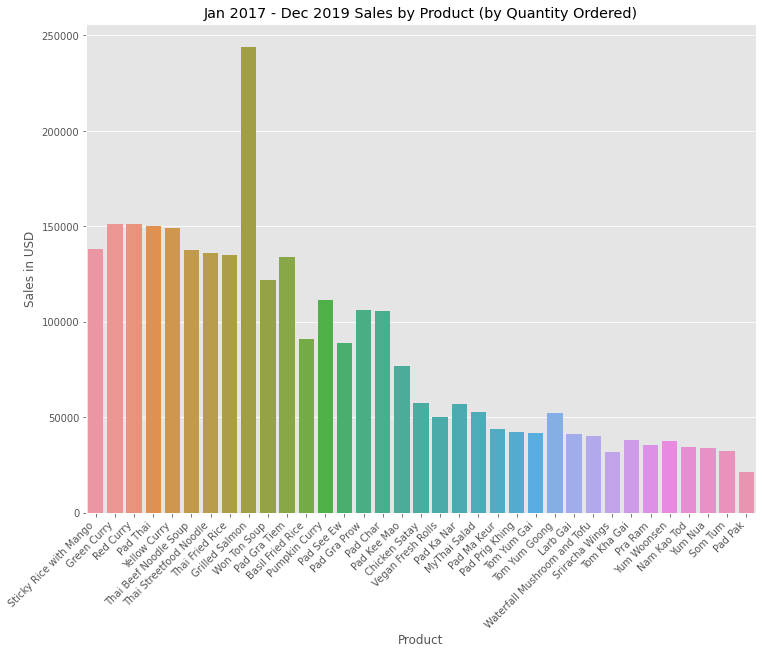

In [14]:
product_popularity = df.groupby('Product').sum().sort_values(by='Quantity Ordered', ascending=False)

plt.figure(figsize=(12,9))
ax = sns.barplot(product_popularity.index, product_popularity['Sales'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')  # rotate if small figsize
plt.title("Jan 2017 - Dec 2019 Sales by Product (by Quantity Ordered)")
plt.ylabel("Sales in USD");

Looks like there's a lot of variation. Also noticing that dishes with non-English names seem to not be selling as well. Might be an idea to switch them to english names?

This is an expenses thing, but it might be a easy change to stop offering the less popular dishes. A bigger menu gives people more variety which is almost never a bad thing, but it's expensive to stock that many different kinds of ingredients.

Maybe remove the least purchased dishes from the menu? Would need some information on how expensive it is to stock/prepare each item, but the business could become more lean this way.

(?) What's the value prop? Is it important to have such variety, or could they focus on doing a few dishes really really well?

Maybe pair the most popular dish with some less popular dishes (to encourage people to try other stuff).

Alternatively, you could pair the most popular dish as a combo with even more popular dishes to get people to buy more. But you might be able to increase overall demand like this. The Bay Area has foodie culture, and if you're known for top tier Thai food and good prices, people will make the trip. In this case, you might want to consider some marketing stuff too.

NOTE: there's an infinite amount of analysis you could do here - you could annotate every dish in the menu with coconut and sort by that if you wanted to. Follow your hunches to avoid being distracted by less important stuff.

### Quantity Ordered?

In [15]:
more_than_one_ordered = df.loc[(df['Quantity Ordered'] > 1)]
one_ordered = df.loc[(df['Quantity Ordered'] == 1)]
# len(more_than_one_ordered) + len(one_ordered)
print(len(more_than_one_ordered) / (len(one_ordered) +len(more_than_one_ordered))*100)
more_than_one_ordered

6.55128134065


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Sales,Year,Month,Weekday,Weekday Value,Hour
4,209402,Yum Woonsen,2,13,2019-12-31 20:51:00,26,2019,12,Tuesday,1,20
45,209376,Chicken Satay,2,10,2019-12-31 19:41:00,20,2019,12,Tuesday,1,19
48,209359,Pad Gra Prow,2,15,2019-12-31 19:38:00,30,2019,12,Tuesday,1,19
51,209364,Yum Woonsen,3,13,2019-12-31 19:36:00,39,2019,12,Tuesday,1,19
62,209394,Pumpkin Curry,2,15,2019-12-31 19:25:00,30,2019,12,Tuesday,1,19
...,...,...,...,...,...,...,...,...,...,...,...
216429,3978,Thai Streetfood Noodle,9,12,2017-01-01 14:05:00,108,2017,1,Sunday,6,14
216450,3958,Thai Fried Rice,2,12,2017-01-01 13:18:00,24,2017,1,Sunday,6,13
216458,3948,Basil Fried Rice,7,12,2017-01-01 13:04:00,84,2017,1,Sunday,6,13
216464,3924,Sticky Rice with Mango,3,6,2017-01-01 12:57:00,18,2017,1,Sunday,6,12


We see that about 6.5% of orders have have more than one item ordered.

### Do they have anything in common? Maybe this could inform combos / discounts?

In [16]:
df.groupby('Quantity Ordered').count()

,Order ID,Product,Price Each,Order Date,Sales,Year,Month,Weekday,Weekday Value,Hour
Quantity Ordered,,,,,,,,,,
1,202309,202309,202309,202309,202309,202309,202309,202309,202309,202309
2,10917,10917,10917,10917,10917,10917,10917,10917,10917,10917
3,474,474,474,474,474,474,474,474,474,474
4,485,485,485,485,485,485,485,485,485,485
5,479,479,479,479,479,479,479,479,479,479
6,460,460,460,460,460,460,460,460,460,460
7,444,444,444,444,444,444,444,444,444,444
8,438,438,438,438,438,438,438,438,438,438
9,486,486,486,486,486,486,486,486,486,486


#### (!) Seeing something funny here: there are as many people ordering 9 quantity as there are ordering 3. Seems fishy. Is now the time to fix that? Do I just ignore it?

Let's assume I just didn't find anything useful in quantity ordered.

# Best, worst months of sales?

Do I care about sales or orders? Probably sales, right? Because orders just influence sales?

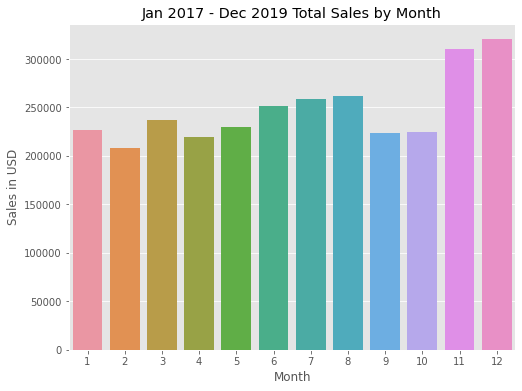

In [17]:
month_total_sales = df.groupby('Month').sum()

plt.figure(figsize=(8,6))
ax = sns.barplot(month_total_sales.index, month_total_sales['Sales'])

plt.title("Jan 2017 - Dec 2019 Total Sales by Month")
plt.ylabel("Sales in USD");

This just shows gets us an idea of how much money we're looking at. It's cumulative months, so we'll probably look by month by year in a bit. But this is a quick way to get a picture of where things are.

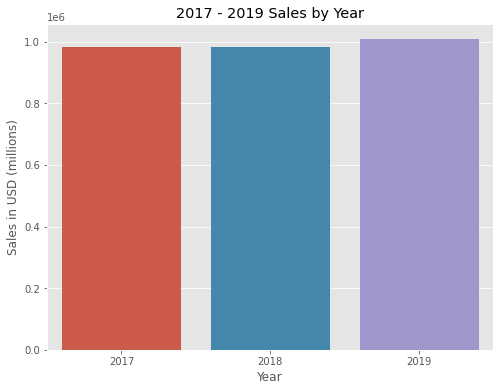

In [18]:
year_sales = df.groupby('Year').sum()

plt.figure(figsize=(8,6))
ax = sns.barplot(year_sales.index, year_sales['Sales'])

plt.title("2017 - 2019 Sales by Year")
plt.ylabel("Sales in USD (millions)");

Sales look similar between years. Trending upwards, but not significantly enough to note. 2019's sales are 1% higher than 2017's (+$26077 in net sales).

This isn't a new restaurant, so it's likely the demand has settled to the market. It's beyond the scope of this analysis, but you could look at trends for other restaurants in the area to get an idea of how much the area affects sales (as opposed to effort from the restaurant team). 

2019 is also the first year the restaurant exceeded $1M in annual sales. Congrats!

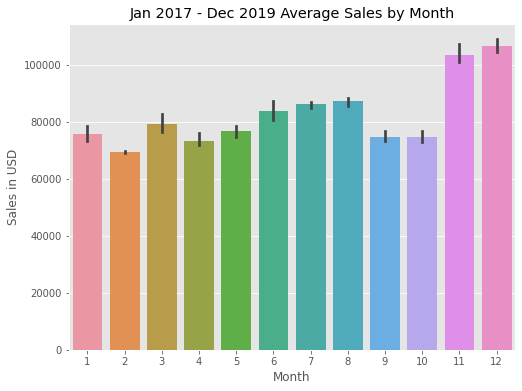

In [19]:
month_sales = df.groupby(['Year', 'Month']).sum().reset_index()

plt.figure(figsize=(8,6))  # figsize not applying for some reason
ax = sns.barplot(data=month_sales, x='Month', y='Sales')

plt.title("Jan 2017 - Dec 2019 Average Sales by Month")
plt.ylabel("Sales in USD");

# check: most of the highest values are from 2019
# sales_2019 = df.loc[(df['Year']==2019)]
# month_sales_2019 = sales_2019.groupby('Month').sum()
# ax = sns.pointplot(month_sales_2019.index, month_sales_2019['Sales'], marker='.', join=False)

This shows us the average sales per month, as well as the highest and lowest recorded in any year. Note that most of the highest values are from 2019, as the restaurants business has been trending (slightly) upwards.

We mostly see that November and December are significantly higher, and that the summer months are slightly higher. February looks really low, but it might just be because it has slightly less days.

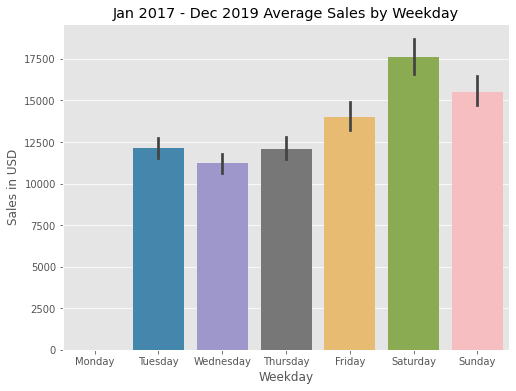

In [20]:
# average weekday sales with range
weekday_sales_without_monday = df.groupby(['Year', 'Month', 'Weekday Value', 'Weekday']).sum().reset_index()
weekday_sales = pd.DataFrame(columns=weekday_sales_without_monday.columns)

monday_row = {'Weekday': 'Monday', 'Sales': 0}  # show mondays are closed
weekday_sales = weekday_sales.append(monday_row, ignore_index=True)
weekday_sales = pd.concat([weekday_sales, weekday_sales_without_monday]).reset_index(drop=True)

plt.figure(figsize=(8,6))
ax = sns.barplot(data=weekday_sales, x='Weekday', y='Sales')

# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')  # rotate if small figsize
plt.title("Jan 2017 - Dec 2019 Average Sales by Weekday")
plt.ylabel("Sales in USD");

From looking at the weekdays, we see that tuesdays are pretty consistently the least popular days of the week. There's a dip, so could we add money by opening on Mondays instead of Wednesdays?

(!) Note these are really ranges, not confidence intervals. 

#### So the hypothesis is that opening on Mondays instead of Wednesdays will increase sales by X amount. We will open on Mondays for a month, and afterwards will consider it a success if the Monday sales are in X range.

If we make more money over the course of a month on Mondays than we do on Wednesdays, that's obviously a good thing. We can value the experiment by taking the the change in revenue from Monday/Wednesday minus the amount of effort/labor that went into the experiment.

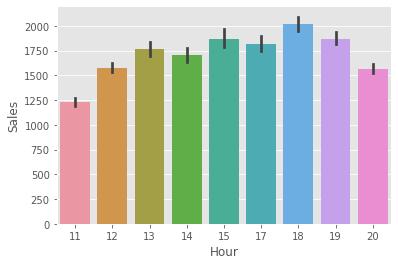

In [21]:
hour_sales = df.groupby(['Year', 'Month', 'Weekday', 'Hour']).sum().reset_index()

# plt.figure(figsize=(8,6))
ax = sns.barplot(data=hour_sales, x='Hour', y='Sales')

# plt.title("Jan 2017 - Dec 2019 Average Sales by Hour")
# plt.ylabel("Sales in USD (millions)");

This gives averages and ranges, but doesn't do a good job showing that there aren't an equal amount of hours. Maybe they should just be open 12-4 every day...

# (!) breakpoint - need to think about this more. will return.

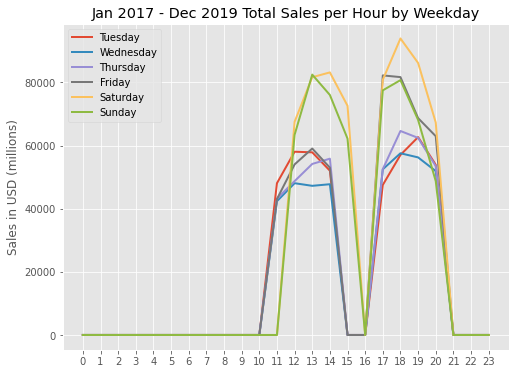

In [22]:
weekdays = ['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(8,6))

for weekday in weekdays:
    day_sales_filtered = df.loc[(df['Weekday'] == weekday)]
    day_sales = day_sales_filtered.groupby('Hour').sum()
    day_values = []
    for hour in range(0,24):
        if hour not in day_sales.index:
            day_values.append(0)
        else:
            day_values.append(day_sales["Sales"][hour])
    ax = sns.lineplot(x=range(0,24), y=day_values, label=weekday, linewidth=2)

plt.xticks(list(range(24)))
plt.ylabel("Sales in USD (millions)")
plt.title("Jan 2017 - Dec 2019 Total Sales per Hour by Weekday");

# plt.savefig("2019_Sales.png", dpi=100, bbox_inches='tight')

We can see here that Wednesday is pretty much the lowest day (even lower than Tuesday or Thursday), so maybe switching the off day from Monday to Wednesday might be something to try.

At a glance, you might consider changing up weekday hours from 11am-3pm to 12pm-4pm since the sales are higher there. But we can be pretty sure that weekend hours and customer availability are much better on weekends.

# (!) the hours don't seem to be right

In [23]:
hour_sales = df.groupby(['Year', 'Month', 'Weekday', 'Hour']).sum().reset_index()
hour_sales

,Year,Month,Weekday,Hour,Order ID,Quantity Ordered,Price Each,Sales,Weekday Value
0,2017,1,Friday,11,496261,76,899,914,300
1,2017,1,Friday,12,683932,128,1236,1468,428
2,2017,1,Friday,13,671152,106,1273,1328,408
3,2017,1,Friday,14,561779,98,1061,1212,344
4,2017,1,Friday,17,881278,153,1665,1973,536
...,...,...,...,...,...,...,...,...,...
1723,2019,12,Wednesday,14,24645033,150,1444,1772,240
1724,2019,12,Wednesday,17,28721910,152,1708,1820,280
1725,2019,12,Wednesday,18,26709518,140,1596,1711,260
1726,2019,12,Wednesday,19,27520484,150,1617,1809,268


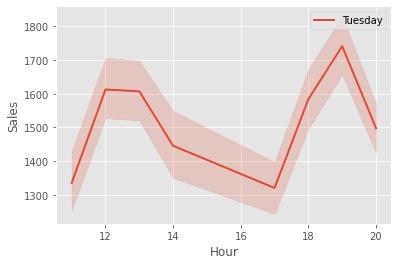

In [24]:
# think more about what you're trying to visualize here

weekday = 'Tuesday'
hour= 12

hour_sales = df.groupby(['Year', 'Month', 'Weekday', 'Hour']).sum().reset_index()
filter_by_weekday = hour_sales.loc[(hour_sales['Weekday'])==weekday]
filter_by_hour = filter_by_weekday.loc[(filter_by_weekday['Hour'])==hour]
filter_by_hour

ax = sns.lineplot(data=filter_by_weekday, x='Hour', y='Sales', label=weekday, linewidth=2)
# plt.xticks(ticks=[range(24)])

In [25]:
# filter_by_hour

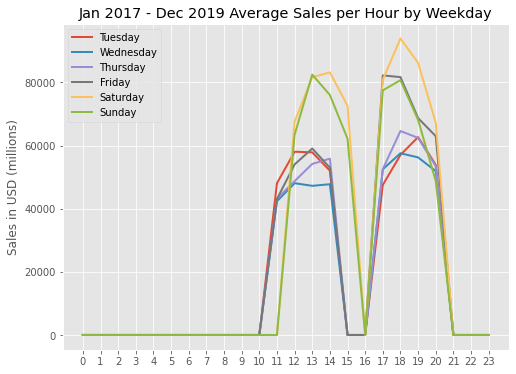

In [26]:
# let's get it with a multiindex?

weekdays = ['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

hour_sales = df.groupby(['Year', 'Month', 'Weekday', 'Hour']).sum().reset_index()


plt.figure(figsize=(8,6))

for weekday in weekdays:
    day_sales_filtered = df.loc[(df['Weekday'] == weekday)]
    day_sales = day_sales_filtered.groupby('Hour').sum()
    day_values = []
    for hour in range(0,24):
        if hour not in day_sales.index:
            day_values.append(0)
        else:
            day_values.append(day_sales["Sales"][hour])
    ax = sns.lineplot(x=range(0,24), y=day_values, label=weekday, linewidth=2)

    
    
plt.xticks(range(24))
plt.ylabel("Sales in USD (millions)")
plt.title("Jan 2017 - Dec 2019 Average Sales per Hour by Weekday");

# plt.savefig("2019_Sales.png", dpi=100, bbox_inches='tight')

In [27]:
range(24)

range(0, 24)

Maybe remove the least purchased dishes from the menu? Would need some information on how expensive it is to stock/prepare each item, but the business could become more lean this way.

(?) What's the value prop? Is it important to have such variety, or could they focus on doing a few dishes really really well?

Maybe pair the most popular dish with some less popular dishes (to encourage people to try other stuff).

Alternatively, you could pair the most popular dish as a combo with even more popular dishes to get people to buy more. But you might be able to increase overall demand like this. The Bay Area has foodie culture, and if you're known for top tier Thai food and good prices, people will make the trip. In this case, you might want to consider some marketing stuff too.

### Conceptualize restaurant revenue model --> move downwards after exploration complete!

### (?) We can use a conceptual model of the restaurant's revenue to check we haven't missed anything huge.

Now that we've seen the data, let's build a basic business model so we have an idea of what to look for. The restaurant's revenue model can be conceptualized as a product of two major factors:
1. How many people eat at the restaurant? (How many orders will it get?)
2. What do those customers eat? (How much is each order worth?)

We can create a basic revenue model by considering the drivers of those two factors. (Red notes drivers we can directly affect). 

![](revenue_model.jpg)

Here are some questions that might be helpful to think about during our initial exploration:
* What hours are the best? (check against sales and orders)
* What items are the most popular? (We can try combo meals instead of simply dropping prices)
##### (?) if we increase value offered, will the cost/order go up?

It's out of scope for this notebook, but you could also consider deeper analysis such as:
* Market trends in the area
* Competitive analysis on other restaurants in the area, especially Thai restaurants
* Does the ordering of the menu items affect the menu?

# A/B Test suggestions

1. Close on Wednesdays instead of Mondays (if you were really worried, you could try staying open 7 days/week, but I recognize that's not realistic).
2. Offer combos? (pair w/ marketing of value proposition)

# Non-test recommendations (!) Give insights, ordered recommendations, and suggestions for things to test.

1. Stop offering so many items.
2. Note which items are vegan/vegetarian.
3. Consider hiring help to be open for more hours (instead of closing during the day)

It looks way important to be open for December. Run a calculation that shows just how important. Seriously, hire seasonal help. 


Note on combos: Offering combos increases the value proposition, which might increase the sales from customers who are already in the restaurant. But to really make it worth it (cost-benefit analysis the 'worth-it' here because it might be worth it with that alone), you would want to engage in some kind of marketing, or way to amplify the customers who make it to your store. Marketing your value proposition.

In the next notebook, we'll look at experimental design and assume we weren't the one who did the analysis role.

### Other stuff to add in the future

These are low priority things that are are a bit out of scope, since we already have a bunch of high priority recommendations.
- time series forecast on revenue

# NOTES

I'm just exploring the data. Is there anything specific I can already look for?

1. Sales (break down by times?)

(?) should PRODUCT column just be 'Order' or 'Item'?

(!) order date is time accurate, not order ID... woops.